# Networks

## Introduction 

This tutorial gives an overview of the microwave network analysis 
features of **skrf**.  For this tutorial, and the rest of the scikit-rf documentation, it is  assumed that **skrf** has been imported as `rf`. Whether or not you follow this convention in your own code is up to you.

In [1]:
import skrf as rf
from pylab import *

If this produces an import error, please see [Installation ](Installation.ipynb).

## Creating Networks


**skrf** provides an object for a N-port microwave [Network](../api/network.rst). A [Network](../api/network.rst) can be created in a number of ways:
 - from a Touchstone file
 - from S-parameters
 - from Z-parameters
 - from other RF parameters (Y, ABCD, T, etc.) 
 
Some examples for each situation is given below.

### Creating Network from Touchstone file
[Touchstone file](https://en.wikipedia.org/wiki/Touchstone_file) (`.sNp` files, with `N` being the number of ports) is a _de facto_ standard to export N-port network parameter data and noise data of linear active devices, passive filters, passive devices, or interconnect networks. Creating a Network from a Touchstone file is simple:

In [4]:
from skrf import Network, Frequency

ring_slot = Network('data/ring_slot.s2p')

Note that some softwares, such as ANSYS HFSS, add additional information to the Touchstone standard, such as comments, simulation parameters, Port Impedance or Gamma (wavenumber). These data are also imported if detected. 

	
A short description of the network will be printed out if entered onto the command line
	

In [5]:
ring_slot

2-Port Network: 'ring_slot',  75.0-110.0 GHz, 201 pts, z0=[50.+0.j 50.+0.j]

### Creating Network from s-parameters
Networks can also be created by directly passing values for the `frequency`, `s`-parameters  (and optionally the port impedance `z0`). 

The scattering matrix of a N-port Network is expected to be a Numpy array of shape `(nb_f, N, N)`, where `nb_f` is the number of frequency points and `N` the number of ports of the network.

<img src="figures/arrays_s_vs_f.svg" width="300">

In [6]:
# dummy 2-port network from Frequency and s-parameters
freq = Frequency(1, 10, 101, 'ghz')
s = rand(101, 2, 2) + 1j*rand(101, 2, 2)  # random complex numbers 
# if not passed, will assume z0=50. name is optional but it's a good practice.
ntwk = Network(frequency=freq, s=s, name='random values 2-port') 
ntwk

2-Port Network: 'random values 2-port',  1.0-10.0 GHz, 101 pts, z0=[50.+0.j 50.+0.j]

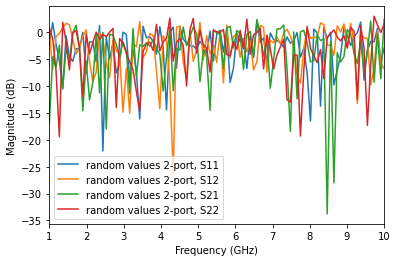

In [7]:
ntwk.plot_s_db()

Often, s-parameters are stored in separate arrays. In such case, one needs to forge the s-matrix:

In [8]:
# let's assume we have separate arrays for the frequency and s-parameters
f = np.array([1, 2, 3, 4]) # in GHz
S11 = np.random.rand(4)
S12 = np.random.rand(4)
S21 = np.random.rand(4)
S22 = np.random.rand(4)

# Before creating the scikit-rf Network object, one must forge the Frequency and S-matrix:
freq2 = rf.Frequency.from_f(f, unit='GHz')

# forging S-matrix as shape (nb_f, 2, 2)
# there is probably smarter way, but less explicit for the purpose of this example:
s = np.zeros((len(f), 2, 2), dtype=complex)
s[:,0,0] = S11
s[:,0,1] = S12
s[:,1,0] = S21
s[:,1,1] = S22

# constructing Network object
ntw = rf.Network(frequency=freq2, s=s)

print(ntw)

2-Port Network: '',  1.0-4.0 GHz, 4 pts, z0=[50.+0.j 50.+0.j]


If necessary, the characteristic impedance can be passed as a scalar (same for all frequencies), as a list or an array:

In [9]:
ntw2 = rf.Network(frequency=freq, s=s, z0=25, name='same z0 for all ports')
print(ntw2)
ntw3 = rf.Network(frequency=freq, s=s, z0=[20, 30], name='different z0 for each port')
print(ntw3)
ntw4 = rf.Network(frequency=freq, s=s, z0=rand(4,2), name='different z0 for each frequencies and ports')
print(ntw4)

2-Port Network: 'same z0 for all ports',  1.0-10.0 GHz, 101 pts, z0=[25.+0.j 25.+0.j]
2-Port Network: 'different z0 for each port',  1.0-10.0 GHz, 101 pts, z0=[20.+0.j 30.+0.j]
2-Port Network: 'different z0 for each frequencies and ports',  1.0-10.0 GHz, 101 pts, z0=[0.26441913+0.j 0.43671122+0.j]


### From z-parameters 

As networks are also defined from their Z-parameters, there is `from_z()` method of the Network:

In [10]:
# 1-port network example
z = np.full((len(freq), 1, 1), 10j)  # replicate z=10j for all frequencies

ntw = rf.Network(frequency=freq, z=z)
print(ntw)

1-Port Network: '',  1.0-10.0 GHz, 101 pts, z0=[50.+0.j]


### From other network parameters: Y, ABCD, H, T
It is also possible to generate Networks from other kind of RF parameters: [Y](https://en.wikipedia.org/wiki/Two-port_network#Admittance_parameters_(y-parameters)), [ABCD](https://en.wikipedia.org/wiki/Two-port_network#ABCD-parameters), [H](https://en.wikipedia.org/wiki/Two-port_network#Hybrid_parameters_(h-parameters)) or [T](https://en.wikipedia.org/wiki/Two-port_network#Scattering_transfer_parameters_(T-parameters)) using the `y=`, `a=`, `h=` or `t=` parameters respectively when creating a `Network`.

For example, the [ABCD parameters](https://en.wikipedia.org/wiki/Two-port_network#ABCD-parameters) of a series-impedance is:
$$
\left[
\begin{array}{cc}
1 & Z \\
0 & 1
\end{array}
\right]
$$
so the associated Network can be created like:

In [11]:
z = 20
abcd = array([[1, z],
              [0, 1]])

a = tile(abcd, (len(freq),1,1))
ntw = Network(frequency=freq, a=a)
print(ntw)

2-Port Network: '',  1.0-10.0 GHz, 101 pts, z0=[50.+0.j 50.+0.j]


Note that convenience functions are also available for converting some parameters into another if required:

| from\to |   S   |   Z   |   Y   |  ABCD |   T   |   H   |
|:-------:|:-----:|:-----:|:-----:|:-----:|:-----:|:-----:|
|    S    |       | `s2z` | `s2y` | `s2a` | `s2t` | `s2h` |
|    Z    | `z2s` |       | `z2y` | `z2a` | `z2t` | `z2h` |
|    Y    | `y2s` | `y2z` |       |       | `y2t` |       |
|   ABCD  | `a2s` | `a2z` |       |       |       |       |
|    T    | `t2s` | `t2z` | `t2y` |       |       |       |
|    H    | `h2s` | `h2z` |       |       |       |       |


In [12]:
# example: converting a -> s
s = rf.a2s(a)
# checking that these S-params are the same
np.all(ntw.s == s)

True

## Basic Properties
	
The basic attributes of a microwave [Network](../api/network.rst) are provided by the following properties :

* `Network.s` : Scattering Parameter matrix. 
* `Network.z0`  : Port Characteristic Impedance matrix.
* `Network.frequency`  : Frequency Object.


The [Network](../api/network.rst) object has numerous other properties and methods. If you are using IPython, then these properties and methods can be 'tabbed' out on the command line. 


	In [1]: ring_slot.s<TAB>
	ring_slot.line.s              ring_slot.s_arcl         ring_slot.s_im
	ring_slot.line.s11            ring_slot.s_arcl_unwrap  ring_slot.s_mag
	...

All of the network parameters are represented internally as complex `numpy.ndarray`. The s-parameters are of shape `(nfreq, nport, nport)`:

In [13]:
shape(ring_slot.s)

(201, 2, 2)

## Slicing

You can  slice the `Network.s` attribute any way you want.

In [14]:
ring_slot.s[:11,1,0]  # get first 10 values of S21

array([0.6134571 +0.36678139j, 0.6218194 +0.36403169j,
       0.63024301+0.36109574j, 0.63872415+0.3579682j ,
       0.64725874+0.35464377j, 0.65584238+0.35111711j,
       0.66447037+0.34738295j, 0.6731377 +0.34343602j,
       0.68183901+0.33927115j, 0.69056862+0.33488321j,
       0.6993205 +0.3302672j ])

In [20]:
ring_slot.z[:11,1,0]

array([0.94703504+30.46757222j, 0.98188607+31.09594438j,
       1.01876516+31.74874257j, 1.05783398+32.42742116j,
       1.09927075+33.13355216j, 1.14327216+33.86883743j,
       1.19005588+34.63512226j, 1.23986317+35.43441087j,
       1.29296211+36.26888384j, 1.34965122+37.14091793j,
       1.41026374+38.05310864j])

Slicing by frequency can also be done directly on Network objects like so 

In [15]:
ring_slot[0:10] #  Network for the first 10 frequency points

2-Port Network: 'ring_slot_subset',  75.0-76.575 GHz, 10 pts, z0=[50.+0.j 50.+0.j]

or  with a human friendly string,

In [16]:
ring_slot['80-90ghz']

2-Port Network: 'ring_slot',  80.075-90.05 GHz, 58 pts, z0=[50.+0.j 50.+0.j]

Notice that slicing directly on a Network **returns a Network**.  So, a nice way to express slicing in both dimensions is 

In [17]:
ring_slot.s11['80-90ghz'] 

1-Port Network: 'ring_slot',  80.075-90.05 GHz, 58 pts, z0=[50.+0.j]

## Plotting 

Amongst other things, the methods of the [Network](../api/network.rst) class provide convenient ways to plot components of the network parameters, 

* `Network.plot_s_db` : plot magnitude of s-parameters in log scale
* `Network.plot_s_deg` : plot phase of s-parameters in degrees
* `Network.plot_s_smith` : plot complex s-parameters on Smith Chart
* ...

If you would like to use skrf's plot styling,

In [18]:
%matplotlib inline 
rf.stylely()

	
To plot all four s-parameters of the `ring_slot` on the Smith Chart.

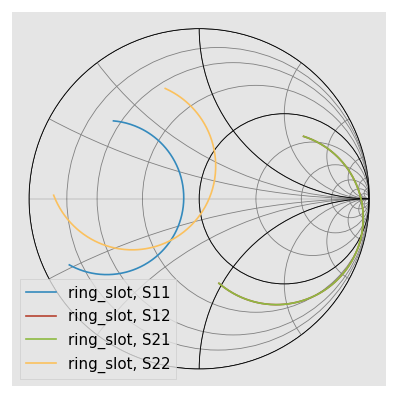

In [19]:
ring_slot.plot_s_smith()

Combining this with the slicing features, 

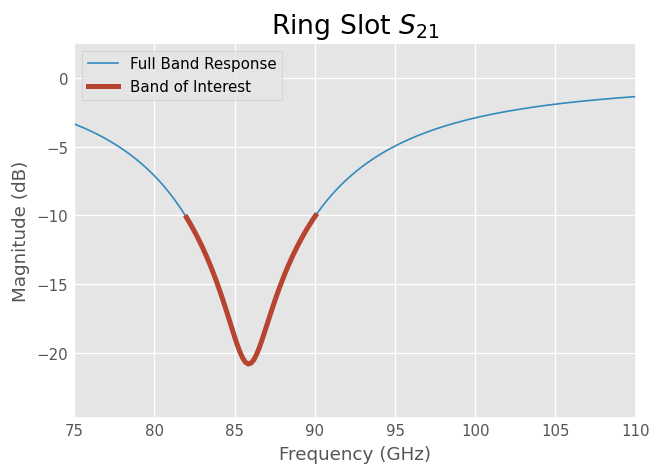

In [21]:
from matplotlib import pyplot as plt

plt.title('Ring Slot $S_{21}$')

ring_slot.s11.plot_s_db(label='Full Band Response')
ring_slot.s11['82-90ghz'].plot_s_db(lw=3,label='Band of Interest')

For more detailed information about plotting see [Plotting](Plotting.ipynb).   

## Arithmetic Operations 
	
Element-wise mathematical operations on the scattering parameter matrices are accessible through overloaded operators. To illustrate their usage, load a couple  Networks stored in the `data` module. 

In [22]:
from skrf.data import wr2p2_short as short 
from skrf.data import wr2p2_delayshort as delayshort 


short - delayshort
short + delayshort
short * delayshort
short / delayshort


1-Port Network: 'wr2p2,short',  330.0-500.0 GHz, 201 pts, z0=[50.+0.j]

All of these operations return [Network](../api/network.rst) types.  For example, to plot the complex difference  between  `short` and `delay_short`,

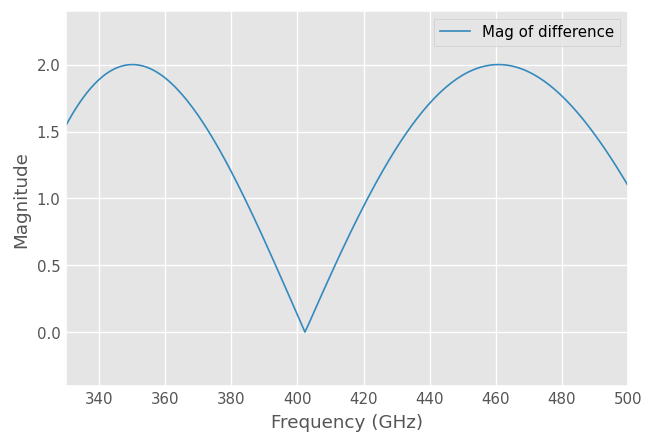

In [23]:
difference = (short - delayshort)
difference.plot_s_mag(label='Mag of difference')

Another common application is calculating the phase difference using the division operator,

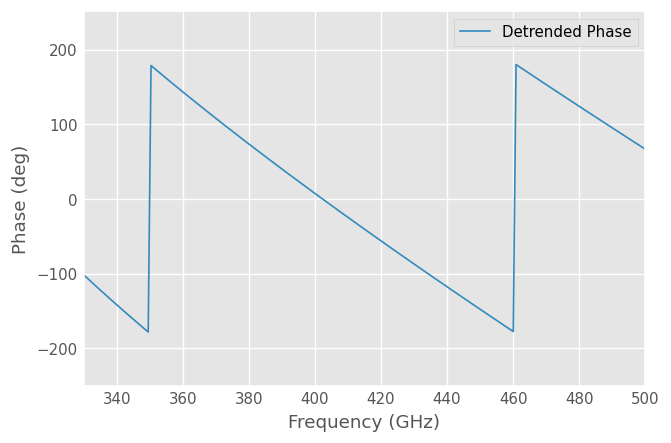

In [24]:
(delayshort/short).plot_s_deg(label='Detrended Phase')

Linear operators can also be used with scalars or an `numpy.ndarray`  that ais the same length as the [Network](../api/network.rst). 

In [25]:
hopen = (short*-1)
hopen.s[:3,...]

array([[[1.-0.j]],

       [[1.-0.j]],

       [[1.-0.j]]])

In [26]:
rando =  hopen *rand(len(hopen))
rando.s[:3,...]

array([[[0.20688497+0.j]],

       [[0.59458785+0.j]],

       [[0.27797059+0.j]]])

## Comparison of Network
Comparison operators also work with networks:

In [27]:
short == delayshort

False

In [28]:
short != delayshort

True

## Cascading and De-embedding

Cascading and de-embeding 2-port Networks can also be done through operators. The `cascade` function can be called through the power operator,  `**`. To calculate a new network which is the cascaded connection of the two individual Networks `line` and `short`, 

In [29]:
short = rf.data.wr2p2_short
line = rf.data.wr2p2_line
delayshort = line ** short

De-embedding  can be accomplished by cascading the *inverse* of a network. The inverse of a network is accessed through the property `Network.inv`. To de-embed the `short` from `delay_short`,

In [30]:
short_2 = line.inv ** delayshort

short_2 == short

True

The cascading operator also works for to 2N-port Networks. This is illustrated in [this example on balanced Networks](../examples/networktheory/Balanced%20Network%20De-embedding.ipynb). For example, assuming you want to cascade three 4-port Network `ntw1`, `ntw2` and `ntw3`, you can use:
`resulting_ntw = ntw1 ** ntw2 ** ntw3`. Note that the port scheme assumed by the `**` cascading operator with 4-port networks is:

```
   ntw1    ntw2    ntw3
  +----+  +----+  +----+
0-|0  2|--|0  2|--|0  2|-2
1-|1  3|--|1  3|--|1  3|-3
  +----+  +----+  +----+
```

More documentation on Connecting Network is available here: [Connecting Networks](./Connecting_Networks.ipynb).

## Connecting Multi-ports 

**skrf** supports the connection of arbitrary ports of N-port networks. It accomplishes this using an algorithm called sub-network growth[[1]](#References),  available through the function `connect()`. 

As an example, terminating one port of an ideal 3-way splitter can be done like so,

In [31]:
tee = rf.data.tee
tee

3-Port Network: 'tee',  330.0-500.0 GHz, 201 pts, z0=[50.+0.j 50.+0.j 50.+0.j]

To connect port `1` of the tee, to port `0` of the delay short,

In [32]:
terminated_tee = rf.connect(tee, 1, delayshort, 0)
terminated_tee

2-Port Network: 'tee',  330.0-500.0 GHz, 201 pts, z0=[50.+0.j 50.+0.j]

Note that this function takes into account port impedances. If two connected ports have different port impedances,  an appropriate impedance mismatch is inserted. 

More information on connecting Networks is available here: [connecting Networks](./Connecting_Networks.ipynb).

For advanced connections between many arbitrary N-port Networks, the `Circuit` object is more relevant since it allows defining explicitly the connections between ports and Networks. For more information, please refer to the [Circuit documentation](Circuit.ipynb). 

	
## Interpolation and Concatenation

A common need is to change the number of frequency points of a [Network](../api/network.rst). To use the operators and cascading functions the networks involved must have matching frequencies, for instance. If two networks have different frequency information, then an error will be raised, 

In [33]:
from skrf.data import wr2p2_line1 as line1

line1

2-Port Network: 'wr2p2,line1',  330.0-500.0 GHz, 101 pts, z0=[50.+0.j 50.+0.j]

    line1+line
    
    ---------------------------------------------------------------------------
    IndexError                                Traceback (most recent call last)
    <ipython-input-49-82040f7eab08> in <module>()
    ----> 1 line1+line

    /home/alex/code/scikit-rf/skrf/network.py in __add__(self, other)
        500 
        501         if isinstance(other, Network):
    --> 502             self.__compatible_for_scalar_operation_test(other)
        503             result.s = self.s + other.s
        504         else:

    /home/alex/code/scikit-rf/skrf/network.py in __compatible_for_scalar_operation_test(self, other)
        701         '''
        702         if other.frequency  != self.frequency:
    --> 703             raise IndexError('Networks must have same frequency. See `Network.interpolate`')
        704 
        705         if other.s.shape != self.s.shape:

    IndexError: Networks must have same frequency. See `Network.interpolate`


	
This problem can be solved by interpolating one of Networks along the frequency axis using `Network.resample`. 

In [ ]:
line1.resample(201)
line1

And now we can do things

In [ ]:
line1 + line

You can also interpolate from a `Frequency` object. For example, 

In [ ]:
line.interpolate(line1.frequency)

A related application is the need to combine Networks which cover different frequency ranges. Two  Networks can be concatenated (aka stitched) together using `stitch`, which  concatenates networks along their frequency axis. To combine a WR-2.2 Network with a WR-1.5 Network, 
 

In [ ]:
from skrf.data import wr2p2_line, wr1p5_line

big_line = rf.stitch(wr2p2_line, wr1p5_line)
big_line

## Reading and Writing 


For long term data storage, **skrf** has support for reading and partial support for writing  [touchstone file format](http://en.wikipedia.org/wiki/Touchstone_file). Reading is accomplished with the Network initializer as shown above,  and writing with the method  `Network.write_touchstone()`.

For **temporary** data storage, **skrf** object can be [pickled](http://docs.python.org/2/library/pickle.html) with  the functions `skrf.io.general.read` and `skrf.io.general.write`.  The reason to use temporary pickles over touchstones is that they store all attributes of a network, while touchstone files only store partial information. 

In [ ]:
rf.write('data/myline.ntwk',line) # write out Network using pickle

In [ ]:
ntwk = Network('data/myline.ntwk') # read Network using pickle

Frequently there is an entire directory of files that need to be analyzed. `rf.read_all`  creates Networks from all files in a directory quickly.  To load all **skrf** files in the `data/` directory which contain the string `'wr2p2'`.

In [ ]:
dict_o_ntwks = rf.read_all(rf.data.pwd, contains = 'wr2p2')
dict_o_ntwks

Other times you know the list of files that need to be analyzed. `rf.read_all`  also accepts a files parameter. This example file list contains only files within the same directory, but you can store files however your application would benefit from.

In [ ]:
import os
dict_o_ntwks_files = rf.read_all(files=[os.path.join(rf.data.pwd, test_file) for test_file in ['ntwk1.s2p', 'ntwk2.s2p']])
dict_o_ntwks_files

## Other Parameters	

This tutorial focuses on s-parameters, but other network representations are available as well. Impedance and Admittance Parameters can be accessed through the parameters `Network.z` and `Network.y`, respectively. Scalar components of complex parameters, such as  `Network.z_re`, `Network.z_im` and plotting methods are available as well.

Other parameters are only available for 2-port networks, such as wave cascading parameters (`Network.t`), and  ABCD-parameters (`Network.a`) or Hybrid parameters (`Network.h`).

In [ ]:
ring_slot.z[:3,...]

In [ ]:
ring_slot.plot_z_im(m=1,n=0)

## References


[1] Compton, R.C.; , "Perspectives in microwave circuit analysis," Circuits and Systems, 1989., Proceedings of the 32nd Midwest Symposium on , vol., no., pp.716-718 vol.2, 14-16 Aug 1989. URL: http://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=101955&isnumber=3167
